# <center>Age and Gender Prediction</center>


The <a href="https://susanqq.github.io/UTKFace/" style="color:#D18358"> UTKFace dataset </a> is a large-scale face dataset consisting of over 20,000 images. The images cover a wide range of ages and races and include both males and females.

Using this dataset, I will be attempting to create a model capable of predicting the age and gender of an individual. I will be using part one of the cropped variations of the images, of which there are almost 10,000. However, I will only be using the first 8000 of these images due to memory limitations.

<div class="list-group" id="list-tab" role="tablist">
  <h3 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home" style="background-color:#D18358; border-color:#D18358">Table of Contents</h3>
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#imports" role="tab" aria-controls="profile" style="color:#8F908E">Imports<span class="badge badge-primary badge-pill" style="background-color:#D18358; border-color:#D18358">1</span></a>
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#load" role="tab" aria-controls="messages" style="color:#8F908E">Loading Data<span class="badge badge-primary badge-pill" style="background-color:#D18358; border-color:#D18358">2</span></a>
  <a class="list-group-item list-group-item-action"  data-toggle="list" href="#visual" role="tab" aria-controls="settings" style="color:#8F908E">Visualising Data<span class="badge badge-primary badge-pill" style="background-color:#D18358; border-color:#D18358">3</span></a>
    <a class="list-group-item list-group-item-action" data-toggle="list" href="#split" role="tab" aria-controls="settings" style="color:#8F908E">Train Test Split<span class="badge badge-primary badge-pill" style="background-color:#D18358; border-color:#D18358">4</span></a>
    <a class="list-group-item list-group-item-action" data-toggle="list" href="#model" role="tab" aria-controls="settings" style="color:#8F908E"> Creating the Model<span class="badge badge-primary badge-pill" style="background-color:#D18358; border-color:#D18358">5</span></a>
    <a class="list-group-item list-group-item-action" data-toggle="list" href="#train" role="tab" aria-controls="settings" style="color:#8F908E">Training the Models<span class="badge badge-primary badge-pill"  style="background-color:#D18358; border-color:#D18358">6</span></a>
    <a class="list-group-item list-group-item-action" data-toggle="list" href="#eval" role="tab" aria-controls="settings" style="color:#8F908E">Evaluating the Models<span class="badge badge-primary badge-pill"  style="background-color:#D18358; border-color:#D18358">7</span></a>  

# <h1 id= 'imports'><span class="label label-default" style="background-color:#D18358; font-size:20px">1. Imports</span></h1>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split
import cv2

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# BatchNormalization
from tensorflow.keras.layers import BatchNormalization

# <h1 id= 'load'><span class="label label-default" style="background-color:#D18358; font-size:20px">2. Loading Data</span></h1>

In [2]:
images = []
ages = []
genders = []

for i in os.listdir('./gender_age/crop_part1')[0:8000]:
    split = i.split('_')
    ages.append(int(split[0]))
    genders.append(int(split[1]))
    images.append(Image.open('./gender_age/crop_part1/' + i))

In [3]:
images = pd.Series(list(images), name = 'Images')
ages = pd.Series(list(ages), name = 'Ages')
genders = pd.Series(list(genders), name = 'Genders')

df = pd.concat([images, ages, genders], axis=1)
df

,Images,Ages,Genders
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,100,1
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,100,1
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,101,1
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,10,0
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,10,0
...,...,...,...
7995,<PIL.JpegImagePlugin.JpegImageFile image mode=...,63,1
7996,<PIL.JpegImagePlugin.JpegImageFile image mode=...,63,1
7997,<PIL.JpegImagePlugin.JpegImageFile image mode=...,63,1
7998,<PIL.JpegImagePlugin.JpegImageFile image mode=...,63,1


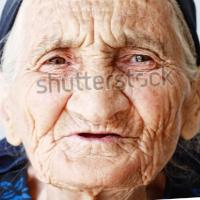

100 1


In [4]:
display(df['Images'][0])
print(df['Ages'][0], df['Genders'][0])

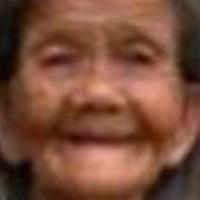

100 1


In [5]:
display(df['Images'][1])
print(df['Ages'][1], df['Genders'][1])

So 0 corresponds to male, 1 corresponds to female.

# <h1 id= 'visual'><span class="label label-default" style="background-color:#D18358; font-size:20px">3. Visualising and Preparing Data</span></h1>

C:\Users\irulg\AppData\Local\Temp\ipykernel_30492\409036286.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Ages'],kde=True, bins=30)


<Axes: xlabel='Ages', ylabel='Density'>

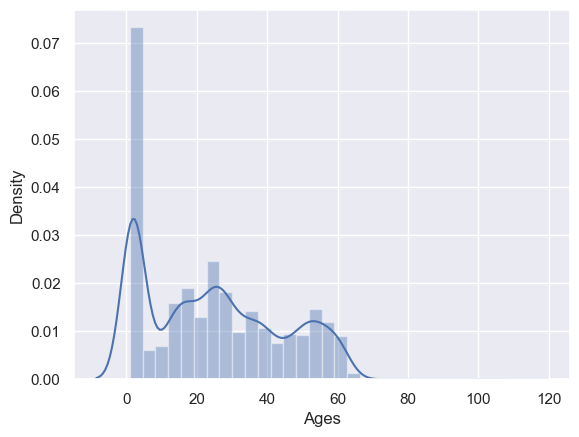

In [6]:
sns.set_theme()
sns.distplot(df['Ages'],kde=True, bins=30)

Too many faces of people between 0 and 4 years old. The model would fit too well to these ages and not enough to the other ages. To resolve this I'm only going to include a third of the images between these ages.

In [7]:
under4s = []

for i in range(len(df)):
    if df['Ages'].iloc[i] <= 4:
        under4s.append(df.iloc[i])
under4s = pd.DataFrame(under4s)
under4s = under4s.sample(frac=0.3)

df = df[df['Ages'] > 4]

df = pd.concat([df, under4s], ignore_index = True)

C:\Users\irulg\AppData\Local\Temp\ipykernel_30492\2036663787.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Ages'],kde=True, bins=30)


<Axes: xlabel='Ages', ylabel='Density'>

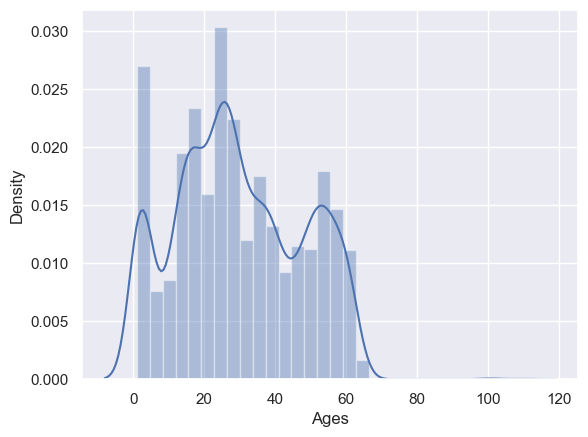

In [8]:
sns.distplot(df['Ages'],kde=True, bins=30)

This looks much better! The dataframe is more representative of the population now. However, there aren't many images of people over 80, which would cause the model to not train well enough on those ages. It's best to just remove over 80s and only have a model that can predict the ages of people under 80.

In [9]:
df = df[df['Ages'] < 80]

C:\Users\irulg\AppData\Local\Temp\ipykernel_30492\2749225890.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Ages'],kde=True, bins=20)


<Axes: xlabel='Ages', ylabel='Density'>

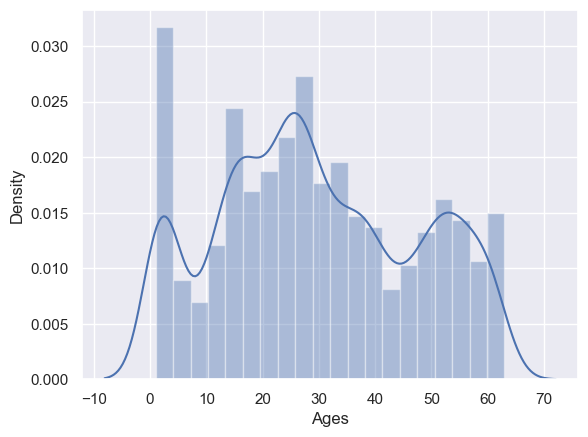

In [10]:
sns.distplot(df['Ages'],kde=True, bins=20)

<Axes: ylabel='count'>

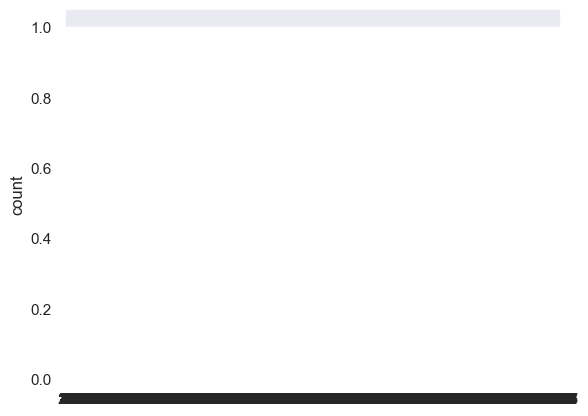

In [11]:
sns.countplot(df['Genders'])

Not sure what 3 corresponds to - both genders, no gender, unknown, or just an error in the data entry? To be safe, I am going to remove any rows where gender equals 3.

<Axes: ylabel='count'>

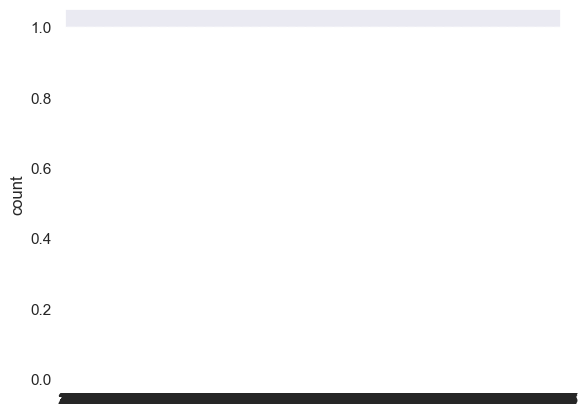

In [12]:
df = df[df['Genders'] != 3]
sns.countplot(df['Genders'])

In [13]:
x = []
y = []

for i in range(len(df)):
    img = Image.open(df['Images'].iloc[i]) if isinstance(df['Images'].iloc[i], str) else df['Images'].iloc[i]
    img_resized = img.resize((200, 200), Image.Resampling.LANCZOS)
    ar = np.asarray(img_resized)
    x.append(ar)
    
    agegen = [int(df['Ages'].iloc[i]), int(df['Genders'].iloc[i])]
    y.append(agegen)

x = np.array(x)


# <h1 id= 'split'><span class="label label-default" style="background-color:#D18358; font-size:20px">4. Train Test Split</span></h1>

In [14]:
y_age = df['Ages']
y_gender = df['Genders']

x_train_age, x_test_age, y_train_age, y_test_age = train_test_split(x, y_age, test_size=0.2, stratify=y_age)
x_train_gender, x_test_gender, y_train_gender, y_test_gender = train_test_split(x, y_gender, test_size=0.2, stratify=y_gender)

# <h1 id= 'model'><span class="label label-default" style="background-color:#D18358; font-size:20px">5. Creating the Models</span></h1>

I will create two individual models - one to predict age and one to predict gender. The age model should be capable of returning continuous values which I will round to the nearest integer, and the gender model should return a binary result.

In [15]:
# Model untuk age prediction
agemodel = Sequential()
agemodel.add(Conv2D(32, (3,3), activation='relu', input_shape=(200, 200, 3)))
agemodel.add(MaxPooling2D((2,2)))
agemodel.add(Conv2D(64, (3,3), activation='relu'))
agemodel.add(MaxPooling2D((2,2)))
agemodel.add(Conv2D(128, (3,3), activation='relu'))
agemodel.add(MaxPooling2D((2,2)))
agemodel.add(Flatten())
agemodel.add(Dense(64, activation='relu'))
agemodel.add(Dropout(0.5))
agemodel.add(Dense(1, activation='relu'))

# BatchNormalization
agemodel.add(BatchNormalization())

agemodel.compile(loss='mean_squared_error',
                 optimizer=optimizers.Adam(learning_rate=0.0001))

# Model untuk gender prediction
genmodel = Sequential()
genmodel.add(Conv2D(32, (3,3), activation='relu', input_shape=(200, 200, 3)))
genmodel.add(MaxPooling2D((2,2)))
genmodel.add(Conv2D(64, (3,3), activation='relu'))
genmodel.add(MaxPooling2D((2,2)))
genmodel.add(Conv2D(128, (3,3), activation='relu'))
genmodel.add(MaxPooling2D((2,2)))
genmodel.add(Flatten())
genmodel.add(Dense(64, activation='relu'))
genmodel.add(Dropout(0.5))
genmodel.add(Dense(1, activation='sigmoid'))

# BatchNormalization
genmodel.add(BatchNormalization())

genmodel.compile(loss='binary_crossentropy',
                 optimizer=optimizers.Adam(learning_rate=0.0001),
                 metrics=['accuracy'])


C:\Users\irulg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# <h1 id= 'train'><span class="label label-default" style="background-color:#D18358; font-size:20px">6. Training the Models</span></h1>

In [16]:
datagen = ImageDataGenerator(
      rescale=1./255., width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale=1./255)

train1 = datagen.flow(x_train_age, y_train_age, batch_size=32)

test1 = test_datagen.flow(
        x_test_age, y_test_age,
        batch_size=32)

history1 = agemodel.fit(train1, epochs=50, shuffle=True, validation_data=test1)
# Save the model
agemodel.save('./models/age_model.h5')

Epoch 1/50


C:\Users\irulg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 110s 634ms/step - loss: 1175.1501 - val_loss: 1201.7828
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 84s 506ms/step - loss: 1168.8955 - val_loss: 1172.1144
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 88s 529ms/step - loss: 1164.5750 - val_loss: 1175.7208
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 93s 555ms/step - loss: 1137.7377 - val_loss: 1165.5673
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 96s 579ms/step - loss: 1152.8925 - val_loss: 1129.6027
Epoch 6/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 91s 545ms/step - loss: 1167.1826 - val_loss: 1115.1156
Epoch 7/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 114s 679ms/step - loss: 1168.5620 - val_loss: 1168.3505
Epoch 8/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 97s 575ms/step - loss: 1131.4775 - val_loss: 1161.9353
Epoch 9/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 95s 572ms/step - loss: 1135.6361 - val_loss: 1154.3054
Epoch 10/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 66s 399ms/step - loss: 1127.2916 - val_loss: 1137.8906
Epoch 11/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 65s 389ms/step - 

In [17]:
datagen = ImageDataGenerator(
      rescale=1./255., width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale=1./255)

train2 = datagen.flow(x_train_gender, y_train_gender, batch_size=64)

test2 = test_datagen.flow(
        x_test_gender, y_test_gender,
        batch_size=64)

history2 = genmodel.fit(train2, epochs=50, shuffle=True, validation_data=test2)
# Save the model
genmodel.save('./models/gen_model.h5')

Epoch 1/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 57s 608ms/step - accuracy: 0.4921 - loss: 6.1062 - val_accuracy: 0.4404 - val_loss: 1.3312
Epoch 2/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 57s 669ms/step - accuracy: 0.4674 - loss: 6.6035 - val_accuracy: 0.4404 - val_loss: 7.4923
Epoch 3/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 53s 625ms/step - accuracy: 0.4853 - loss: 6.1627 - val_accuracy: 0.4404 - val_loss: 4.6824
Epoch 4/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 55s 645ms/step - accuracy: 0.4894 - loss: 6.2098 - val_accuracy: 0.4427 - val_loss: 5.2001
Epoch 5/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 52s 615ms/step - accuracy: 0.4761 - loss: 6.2306 - val_accuracy: 0.4443 - val_loss: 7.0092
Epoch 6/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 54s 640ms/step - accuracy: 0.4884 - loss: 6.2693 - val_accuracy: 0.4512 - val_loss: 5.3577
Epoch 7/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 51s 595ms/step - accuracy: 0.4871 - loss: 6.0092 - val_accuracy: 0.4789 - val_loss: 3.1277
Epoch 8/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 51s 602ms/step - accuracy: 0.5204 - loss: 5.3499 - val_accu

# <h1 id= 'eval'><span class="label label-default" style="background-color:#D18358; font-size:20px">7. Evaluating the Models</span></h1>

Now to evaluate the models I am going to use some external images of celebrities. These celebrities are of a variety of ages and genders.

In [95]:
cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def process_and_predict(file):
    agemodel = tf.keras.models.load_model('./models/age_model.h5')
    genmodel = tf.keras.models.load_model('./models/gen_model.h5')
    # Load image
    im = Image.open(file)
    width, height = im.size
    if width == height:
        im = im.resize((200,200), Image.Resampling.LANCZOS)
    else:
        if width > height:
            left = width/2 - height/2
            right = width/2 + height/2
            top = 0
            bottom = height
            im = im.crop((left,top,right,bottom))
            im = im.resize((200,200), Image.Resampling.LANCZOS)
        else:
            left = 0
            right = width
            top = 0
            bottom = width
            im = im.crop((left,top,right,bottom))
            im = im.resize((200,200), Image.Resampling.LANCZOS)

    # Convert image to numpy array
    ar = np.asarray(im)
    ar = ar.astype('float32')
    ar /= 255.0
    ar = ar.reshape(-1, 200, 200, 3)

    # Predict age and gender
    age = agemodel.predict(ar)
    gender = np.round(genmodel.predict(ar))
    if gender == 0:
        gender = 'male'
    elif gender == 1:
        gender = 'female'

    print('Age:', int(age), '\nGender:', gender)

    # Convert image to OpenCV format
    img_cv2 = np.array(im)
    img_cv2 = cv2.cvtColor(img_cv2, cv2.COLOR_RGB2BGR)

    # Load pre-trained face detector from OpenCV
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

    # Convert image to grayscale for face detection
    gray = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # Draw rectangles around the faces
    for (x, y, w, h) in faces:
        cv2.rectangle(img_cv2, (x, y), (x+w, y+h), (255, 0, 0), 2)

    # Convert back to RGB for displaying with matplotlib
    img_cv2_rgb = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)

    # Display the image with rectangles around faces using matplotlib
    plt.imshow(img_cv2_rgb)
    plt.axis('off')
    plt.show()

# Contoh penggunaan
# process_and_predict('path_to_image.jpg')


## <p style="font-size:20px; color:#D18358"> Deddy Corbuzier </p>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Age: 46 
Gender: male


C:\Users\irulg\AppData\Local\Temp\ipykernel_30492\3042625120.py:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Age:', int(age), '\nGender:', gender)


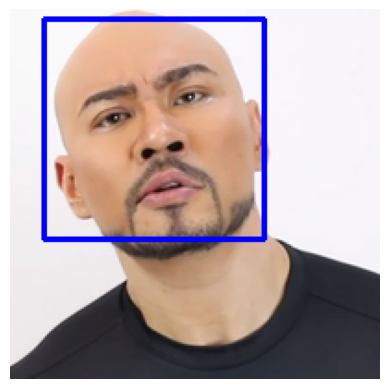

In [96]:
process_and_predict('./tests/deddy.jpg')

## <p style="font-size:20px; color:#D18358"> Freya Jayawardana </p>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Age: 21 
Gender: male


C:\Users\irulg\AppData\Local\Temp\ipykernel_30492\3042625120.py:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Age:', int(age), '\nGender:', gender)


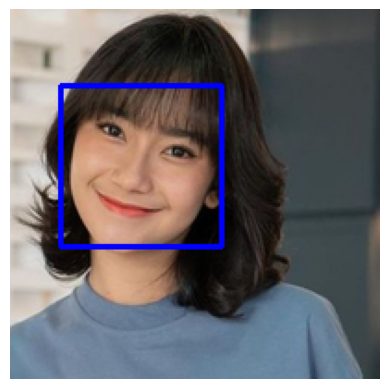

In [97]:
process_and_predict('./tests/freya.jpg')

## <p style="font-size:20px; color:#D18358"> Son Xavier Exel </p>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Age: 13 
Gender: male


C:\Users\irulg\AppData\Local\Temp\ipykernel_30492\3042625120.py:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Age:', int(age), '\nGender:', gender)


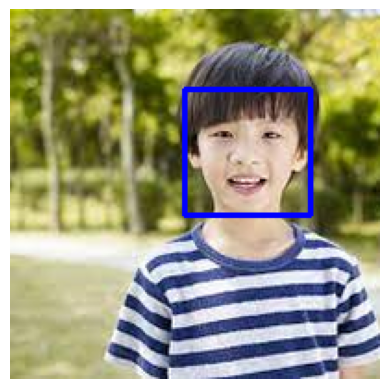

In [98]:
process_and_predict('./tests/son.jpg')

## <p style="font-size:20px; color:#D18358"> Nenek Jawa </p>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Age: 58 
Gender: male


C:\Users\irulg\AppData\Local\Temp\ipykernel_30492\3042625120.py:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Age:', int(age), '\nGender:', gender)


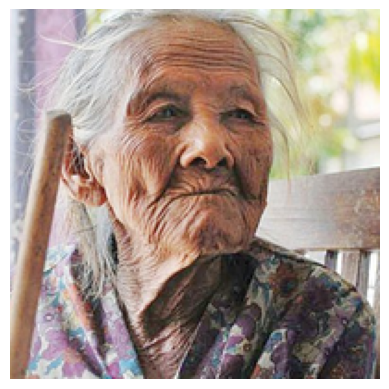

In [99]:
process_and_predict('./tests/grandma.jpg')

## <p style="font-size:20px; color:#D18358"> Laura Basuki </p>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Age: 33 
Gender: male


C:\Users\irulg\AppData\Local\Temp\ipykernel_30492\3042625120.py:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Age:', int(age), '\nGender:', gender)


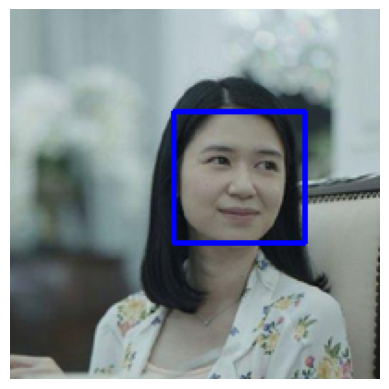

In [100]:
process_and_predict('./tests/laura_basuki.jpg')

You can decide for yourself if you think it worked, but for the most part I think it did quite well, especially for gender where it only got one celebrity incorrect! I hope you enjoyed and thank you for reading!

<p> Special thanks to Marco Vasquez E for his <a style="color:#D18358" href="https://www.kaggle.com/marcovasquez/useful-html-for-jupyter-notebook"> notebook</a> on
Useful HTML for Jupyter Notebook. Couldn't have done the beautiful table of contents without it! </p>

In [3]:
# With openCV for real time prediction
import cv2

# menggunakan model yang sudah di train age_model.h5 dan gen_model.h5
age_model = tf.keras.models.load_model('./models/age_model.h5')
gen_model = tf.keras.models.load_model('./models/gen_model.h5')

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

cap = cv2.VideoCapture(1)

while True:
    ret, frame = cap.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)
    for (x, y, w, h) in faces:
        face = frame[y:y+h, x:x+w]
        face = cv2.resize(face, (200,200))
        face = np.array(face).reshape(-1, 200, 200, 3)
        face = face/255.0
        age = age_model.predict(face)
        gender = np.round(gen_model.predict(face))
        # putText
        mygen = 'Unknown'
        if gender == 0:
            mygen = 'Male'
        elif gender == 1:
            mygen = 'Female'
            
        cv2.putText(frame, f'{int(age)}, {mygen}', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
        cv2.rectangle(frame, (x,y), (x+w, y+h), (255,0,0), 2)
    cv2.imshow('frame', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


C:\Users\irulg\AppData\Local\Temp\ipykernel_23292\2669229409.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cv2.putText(frame, f'{int(age)}, {mygen}', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

: 